In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Importing all the libraries to be used
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn import metrics

# Data Loading

In [14]:
data_path = '/content/drive/MyDrive/SPAM_SMS_DETECTION/spam.csv'
#Loading data
data = pd.read_csv(data_path, encoding='latin-1')


In [9]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [15]:
# Dropping the redundent looking collumns
data = data.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis=1)
# Renaming the columns
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# EDA

In [23]:
import plotly.express as px
import pandas as pd

# Count occurrences
target_counts = data["Target"].value_counts().reset_index()
target_counts.columns = ["Classes", "Number of Data points"]

# Plot using Plotly
fig = px.bar(
    target_counts,
    x="Classes",
    y="Number of Data points",
    color="Classes",
    color_discrete_sequence=["lightgreen", "darkred"],
    title="Count Plot of Classes",
    labels={"Classes": "Classes", "Number of Data points": "Number of Data points"},
)

# Customize layout
fig.update_layout(
    title_font_color="black",
    title_font_size=20,
    xaxis_title_font=dict(color="#58508d"),
    yaxis_title_font=dict(color="#58508d"),
    title_x=0.5,
)

fig.show()


In [25]:
#Adding a column of numbers of charachters,words and sentences in each msg
nltk.download('punkt_tab')
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


<Figure size 1200x800 with 0 Axes>

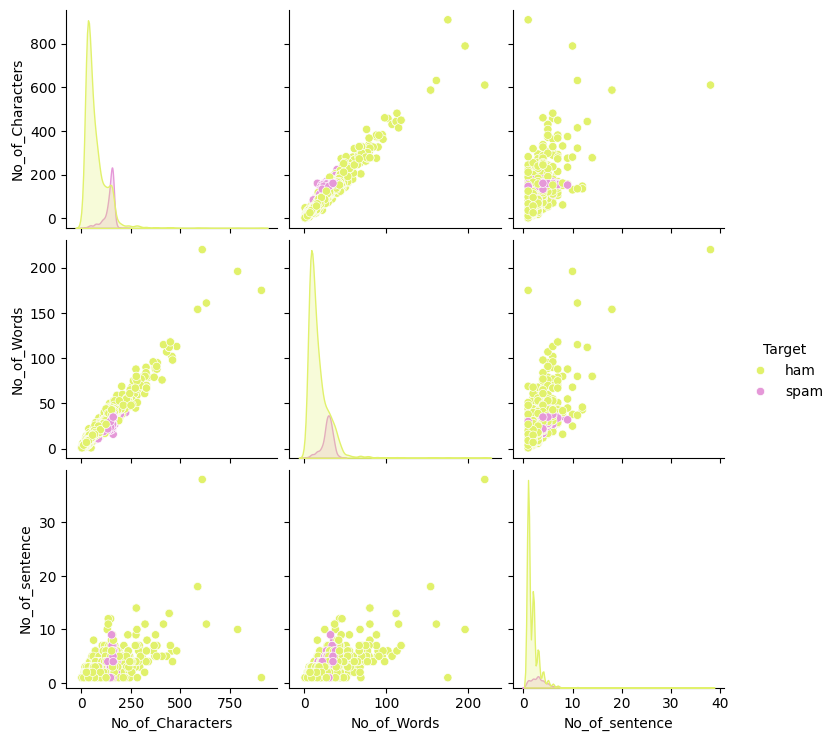

In [27]:
#Palette
cols= ["#E1F16B", "#E598D8"]
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

# Data Preprocessing

In [28]:
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Text"].apply(Clean)

In [35]:
data["Tokenize_Text"]= data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)
data["Tokenize_Text"]

,Tokenize_Text
0,"[go, until, jurong, point, crazy, available, o..."
1,"[ok, lar, joking, wif, u, oni]"
2,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,"[u, dun, say, so, early, hor, u, c, already, t..."
4,"[nah, i, don, t, think, he, goes, to, usf, he,..."
...,...
5567,"[this, is, the, nd, time, we, have, tried, con..."
5568,"[will, b, going, to, esplanade, fr, home]"
5569,"[pity, was, in, mood, for, that, so, any, othe..."
5570,"[the, guy, did, some, bitching, but, i, acted,..."


In [38]:
# Removing the stopwords function
nltk.download('stopwords')
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text


nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)
data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [39]:
data.head()

,Target,Text,No_of_Characters,No_of_Words,No_of_sentence,Clean_Text,Tokenize_Text,Nostopword_Text,Lemmatized_Text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"


# TF-IDF Vectorization

In [40]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)


In [43]:
#Changing text data in to numbers.
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])
data["Target"].head()

,Target
0,0
1,0
2,1
3,0
4,0


# Train Test Split

In [47]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = data["Target"]
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Building

In [48]:
#Testing on the following classifiers
classifiers = [MultinomialNB(),
               RandomForestClassifier(),
               KNeighborsClassifier(),
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [49]:
# Cossvalidation
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.966344 
RandomForest: 0.978012 
KNeighbours: 0.914740 
SVC: 0.976217 


# Model Evaluation

In [50]:
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)

    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [51]:
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,0.990991,0.733333,0.842912,0.976682,0.997981
RandomForest,0.992248,0.853333,0.917563,0.976682,0.997981
KNeighbours,1.000000,0.400000,0.571429,0.976682,0.997981
SVC,0.992063,0.833333,0.905797,0.976682,0.997981


# **As we can see NaiveBayes & SVC perform better. We can go with that !!**